In [29]:
# AUTHOR: ANTTI KIVIAHO
# EMAIL: antti.kiviaho@tuni.fi
#
#
#
# A script for plotting confusion matrices and ROC curves of ready-made prediction results

In [2]:
import os
import sys
from logzero import logger
from matplotlib import pyplot as plt
from itertools import cycle
from scipy import stats

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from enum import IntEnum

from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

from keras.models import load_model

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

class toIntEnum(IntEnum):
    MED12 = 0
    HMGA2 = 1
    UNK = 2
    HMGA1 = 3
    OM = 4
    YEATS4 = 5



In [3]:
res_sheet = 'binary_folds_1-4_2_epochs_100_percent_21892821_at_2022-07-04_07:03:15_598px_binary_prediction_results.csv'
results = pd.read_csv('/lustre/scratch/kiviaho/myoma/myoma-new/'+res_sheet)

tfrecord_contents = pd.read_csv('/lustre/scratch/kiviaho/myoma/myoma-new/fold_5_tfr_contents.tsv')
tfrecord_contents = tfrecord_contents[:len(results)]

results = results.rename(columns={'0': 0, '1': 1})
results = pd.concat([tfrecord_contents.reset_index(drop=True), results], axis=1)
results.dropna(inplace=True)

# Switch ground truth labels to binary.
results['Label'][results['Label'].isin([1,2,3,4,5])] = 1

gt_tile = results['Label']

pred = np.array(results[[0,1]],dtype=np.float32)


/home/ak431480/.conda/envs/myoma-new-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


[D 220709 13:21:41 3456169981:7] Tile Level Confusion Matrix
[I 220709 13:21:42 3456169981:14] [[2812258  341876]
     [ 574726  840572]]
[D 220709 13:21:42 3456169981:16] Classification Report
[I 220709 13:21:52 3456169981:19]                         precision    recall  f1-score   support
    
    MED12 mut 
     (3.15e+06)      0.830     0.892     0.860   3154134
     MED12 wt 
     (1.42e+06)      0.711     0.594     0.647   1415298
    
                  accuracy                          0.799   4569432
                 macro avg      0.771     0.743     0.754   4569432
              weighted avg      0.793     0.799     0.794   4569432
    


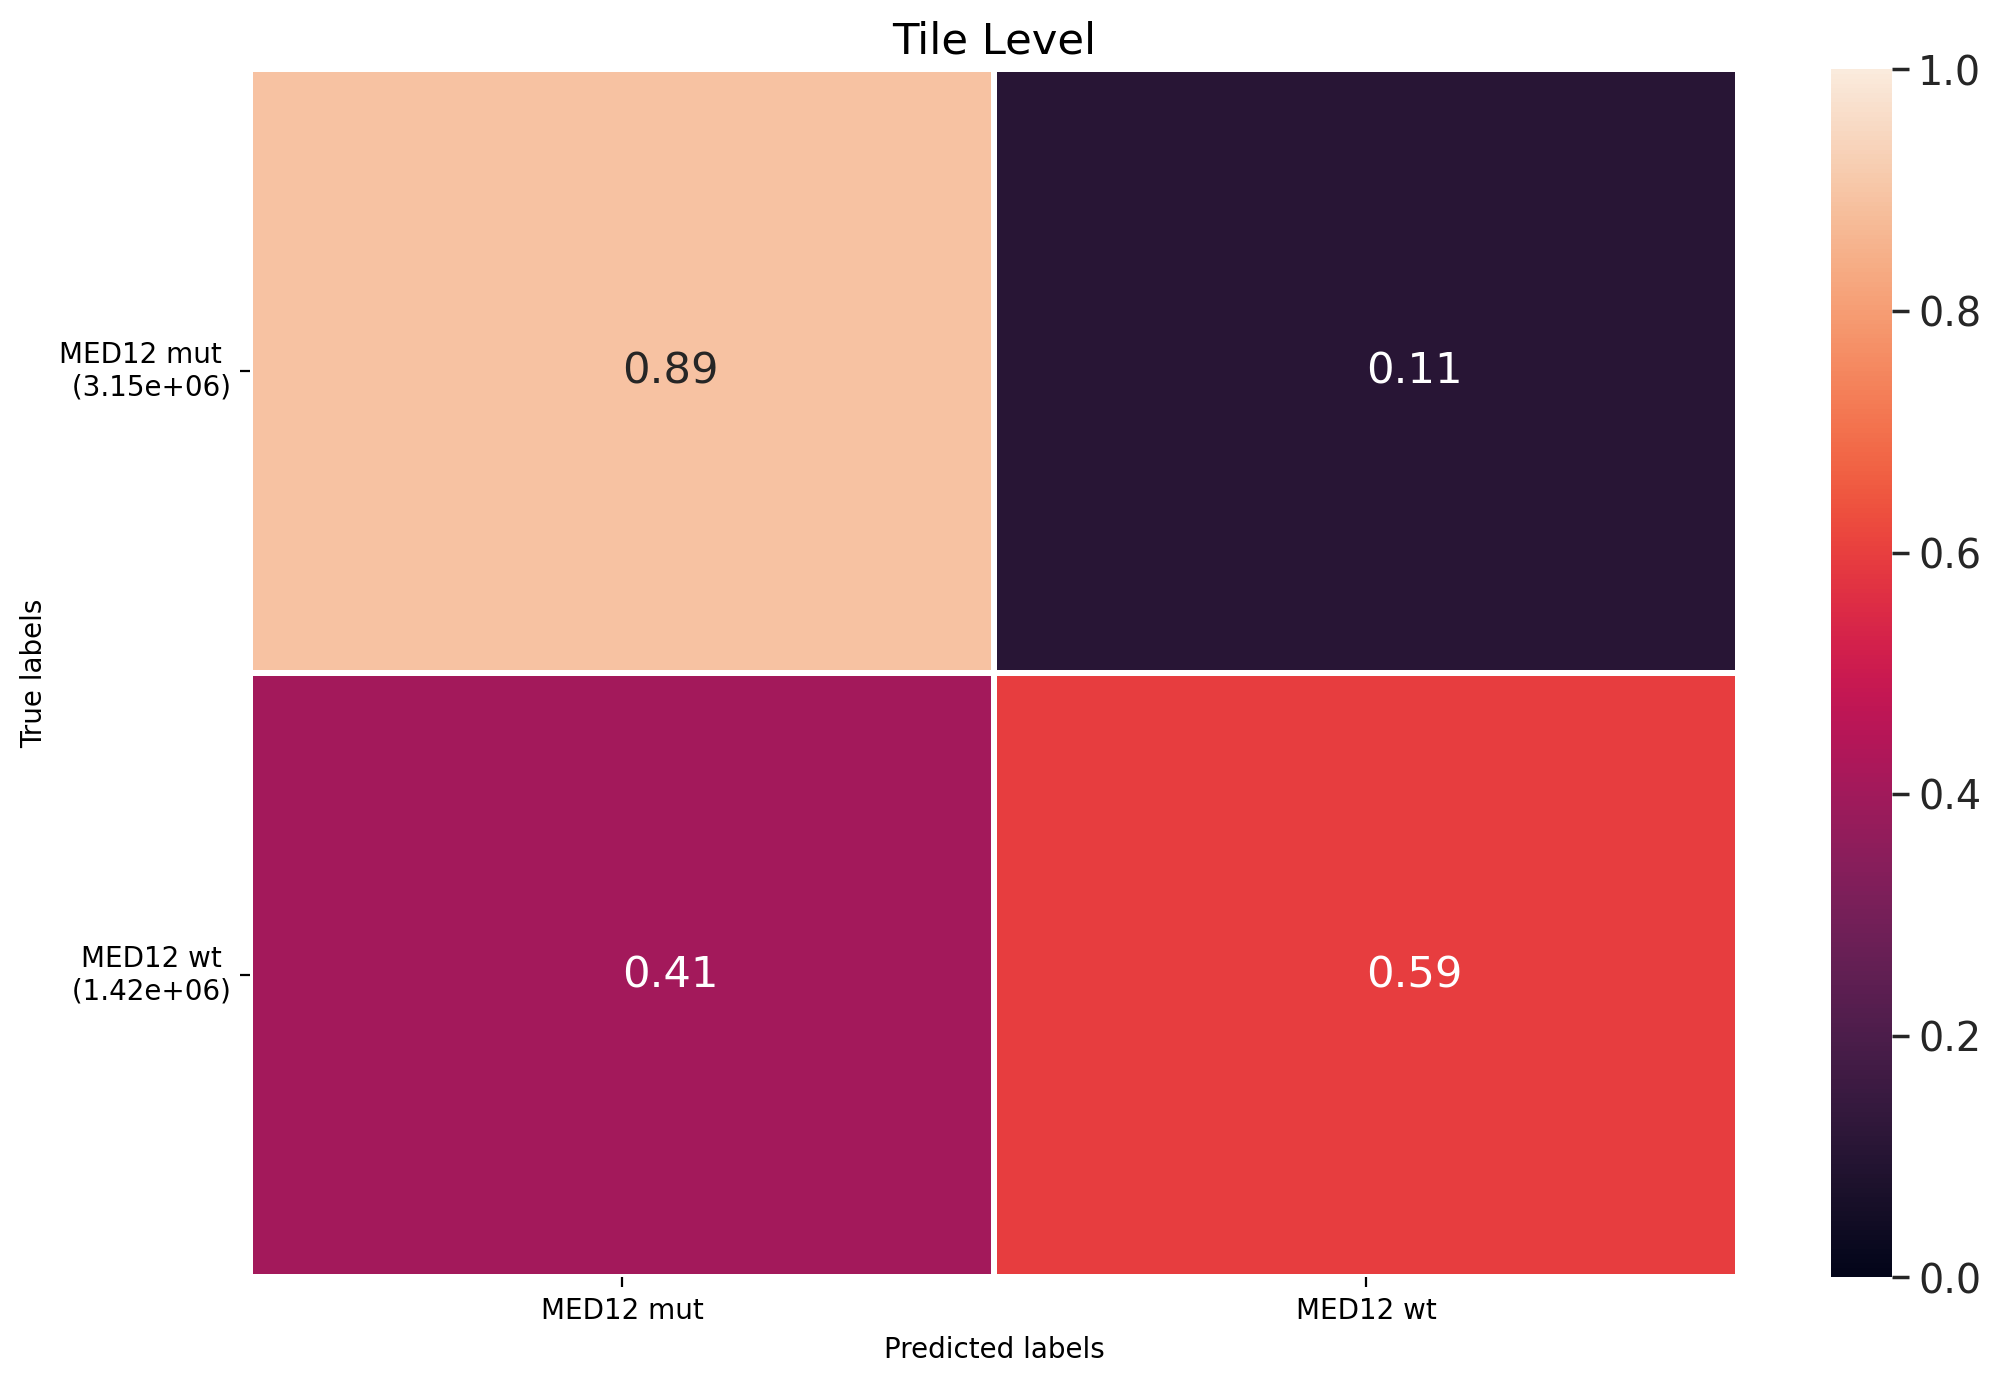

In [4]:
# get predictions into single column
# for confusion matrix
probs = results.loc[:,[0,1]]

predictions = probs.idxmax(axis=1)

logger.debug("Tile Level Confusion Matrix")
cm = confusion_matrix(gt_tile, predictions)


target_names = ['MED12 mut \n ({:.2e})'.format(np.sum(cm[0,:])),
                'MED12 wt \n ({:.2e})'.format(np.sum(cm[1,:]))]
predict_names = ['MED12 mut', 'MED12 wt']
logger.info(cm)

logger.debug("Classification Report")
cr = classification_report(gt_tile, predictions,
                            target_names=target_names,digits=3)
logger.info(cr)


# Switch to percentage. Remember to switch sns.heatmap(fmt='.2e' to fmt='.2%')
cm = cm/cm.sum(axis=1, keepdims=True)


ax1 = plt.subplot(111)
akws = {"ha": 'left',"va": 'center'}

sns.set_theme(font_scale=1.3)
sns.heatmap(cm, annot=cm, ax = ax1, fmt='.2f', annot_kws=akws,linewidths=2,
            cbar =True, linecolor='white', vmin=0.,vmax=1.)

# labels, title and ticks
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.set_title("Tile Level")
ax1.xaxis.set_ticklabels(predict_names)
ax1.yaxis.set_ticklabels(target_names,rotation = 0)
ax1.figure.set_size_inches((12,8))
ax1.figure.set_dpi(200)



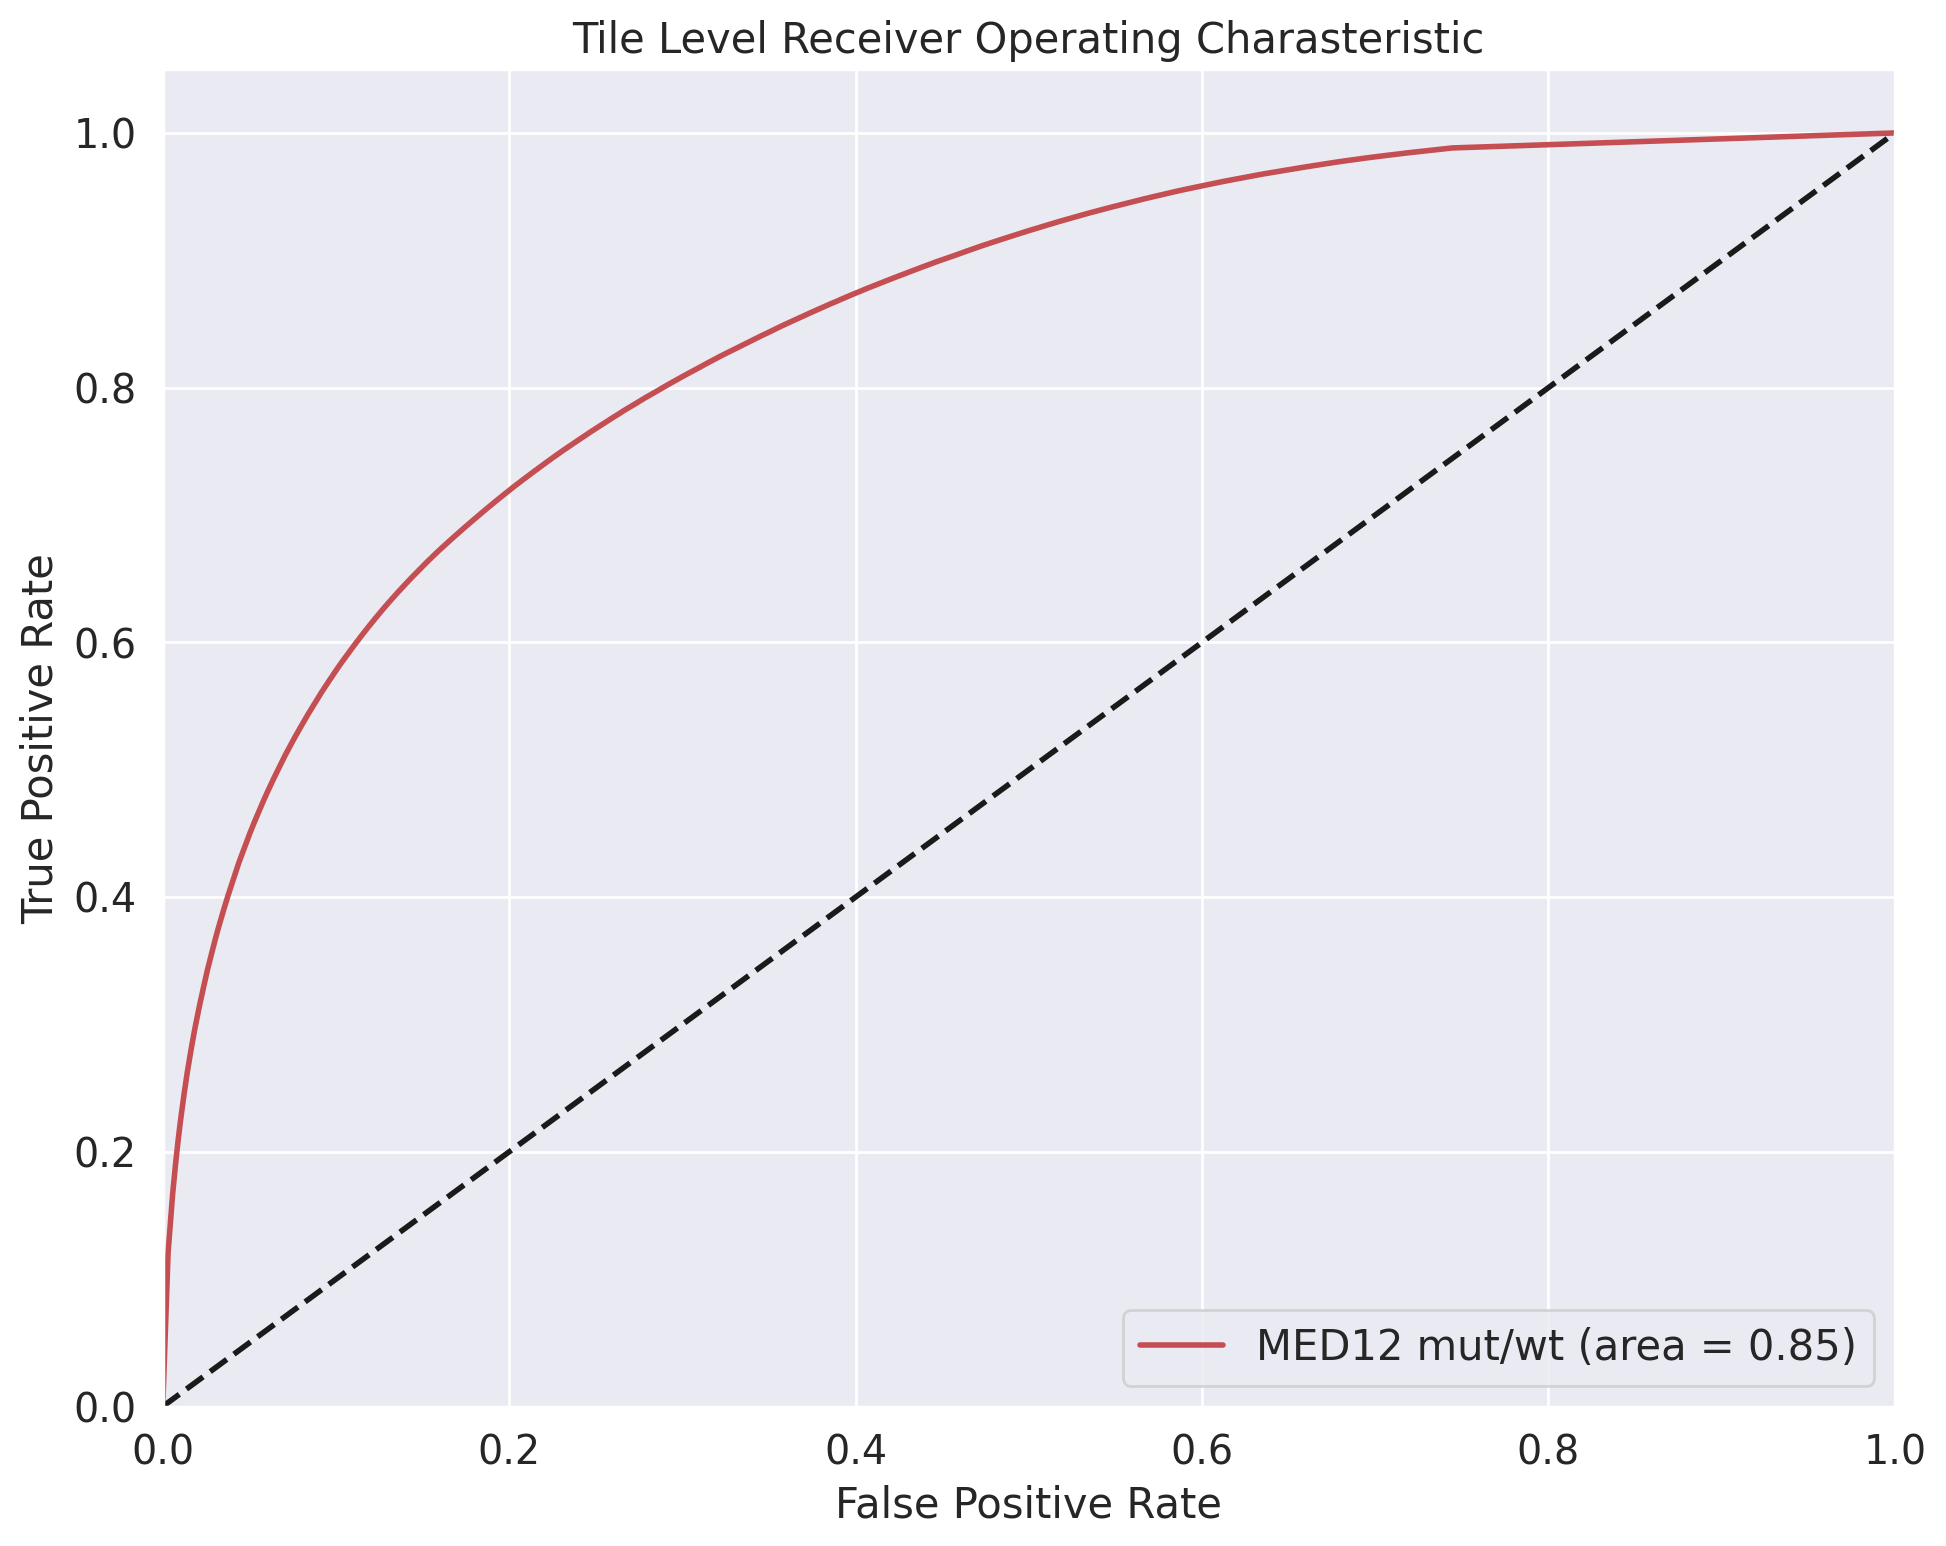

In [11]:
n_classes = 2
predict_names = ['MED12 mut', 'MED12 wt']
lw = 2

results_mod = results
gt_tile_mod = np.squeeze(np.array(gt_tile,dtype=np.int16))

gt_tile_mod = np.array(tf.one_hot(gt_tile_mod,n_classes),dtype=np.int16)
results_mod = np.array(results_mod.loc[:,[0,1]],dtype=np.float32)


fpr, tpr, _ = roc_curve(gt_tile_mod[:,1], results_mod[:,1])
roc_auc = auc(fpr, tpr)

# Then interpolate all ROC curves at this points
# Plot all ROC curves
plt.figure(figsize=(10, 8), dpi=200)

plt.plot(
    fpr,
    tpr,
    color='r',
    lw=lw,
    label= "MED12 mut/wt" + " (area = %0.2f)" % roc_auc,
)

plt.plot([0, 1], [0, 1], "k--", lw=lw,)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate",size=15)
plt.ylabel("True Positive Rate",size=15)
plt.title("Tile Level Receiver Operating Charasteristic",size=15)
plt.legend(loc="lower right",prop={'size': 15})
plt.tight_layout()
#plt.savefig(filename + '_ROC_tile_level.png', dpi=300)


In [13]:
#concat_results = pd.concat([tfrec_info.reset_index(drop=True), results], axis=1)

sample_level = results.loc[:,['Sample','Label',0,1]].groupby(['Sample']).mean()
gt_sample = sample_level.loc[:,['Label']]

[D 220709 13:25:55 107202113:10] Confusion Matrix
[I 220709 13:25:55 107202113:12] [[72  0]
     [11 23]]
[D 220709 13:25:55 107202113:18] Classification Report
[I 220709 13:25:55 107202113:21]                 precision    recall  f1-score   support
    
    MED12 mut (72)      0.867     1.000     0.929        72
     MED12 wt (34)      1.000     0.676     0.807        34
    
          accuracy                          0.896       106
         macro avg      0.934     0.838     0.868       106
      weighted avg      0.910     0.896     0.890       106
    


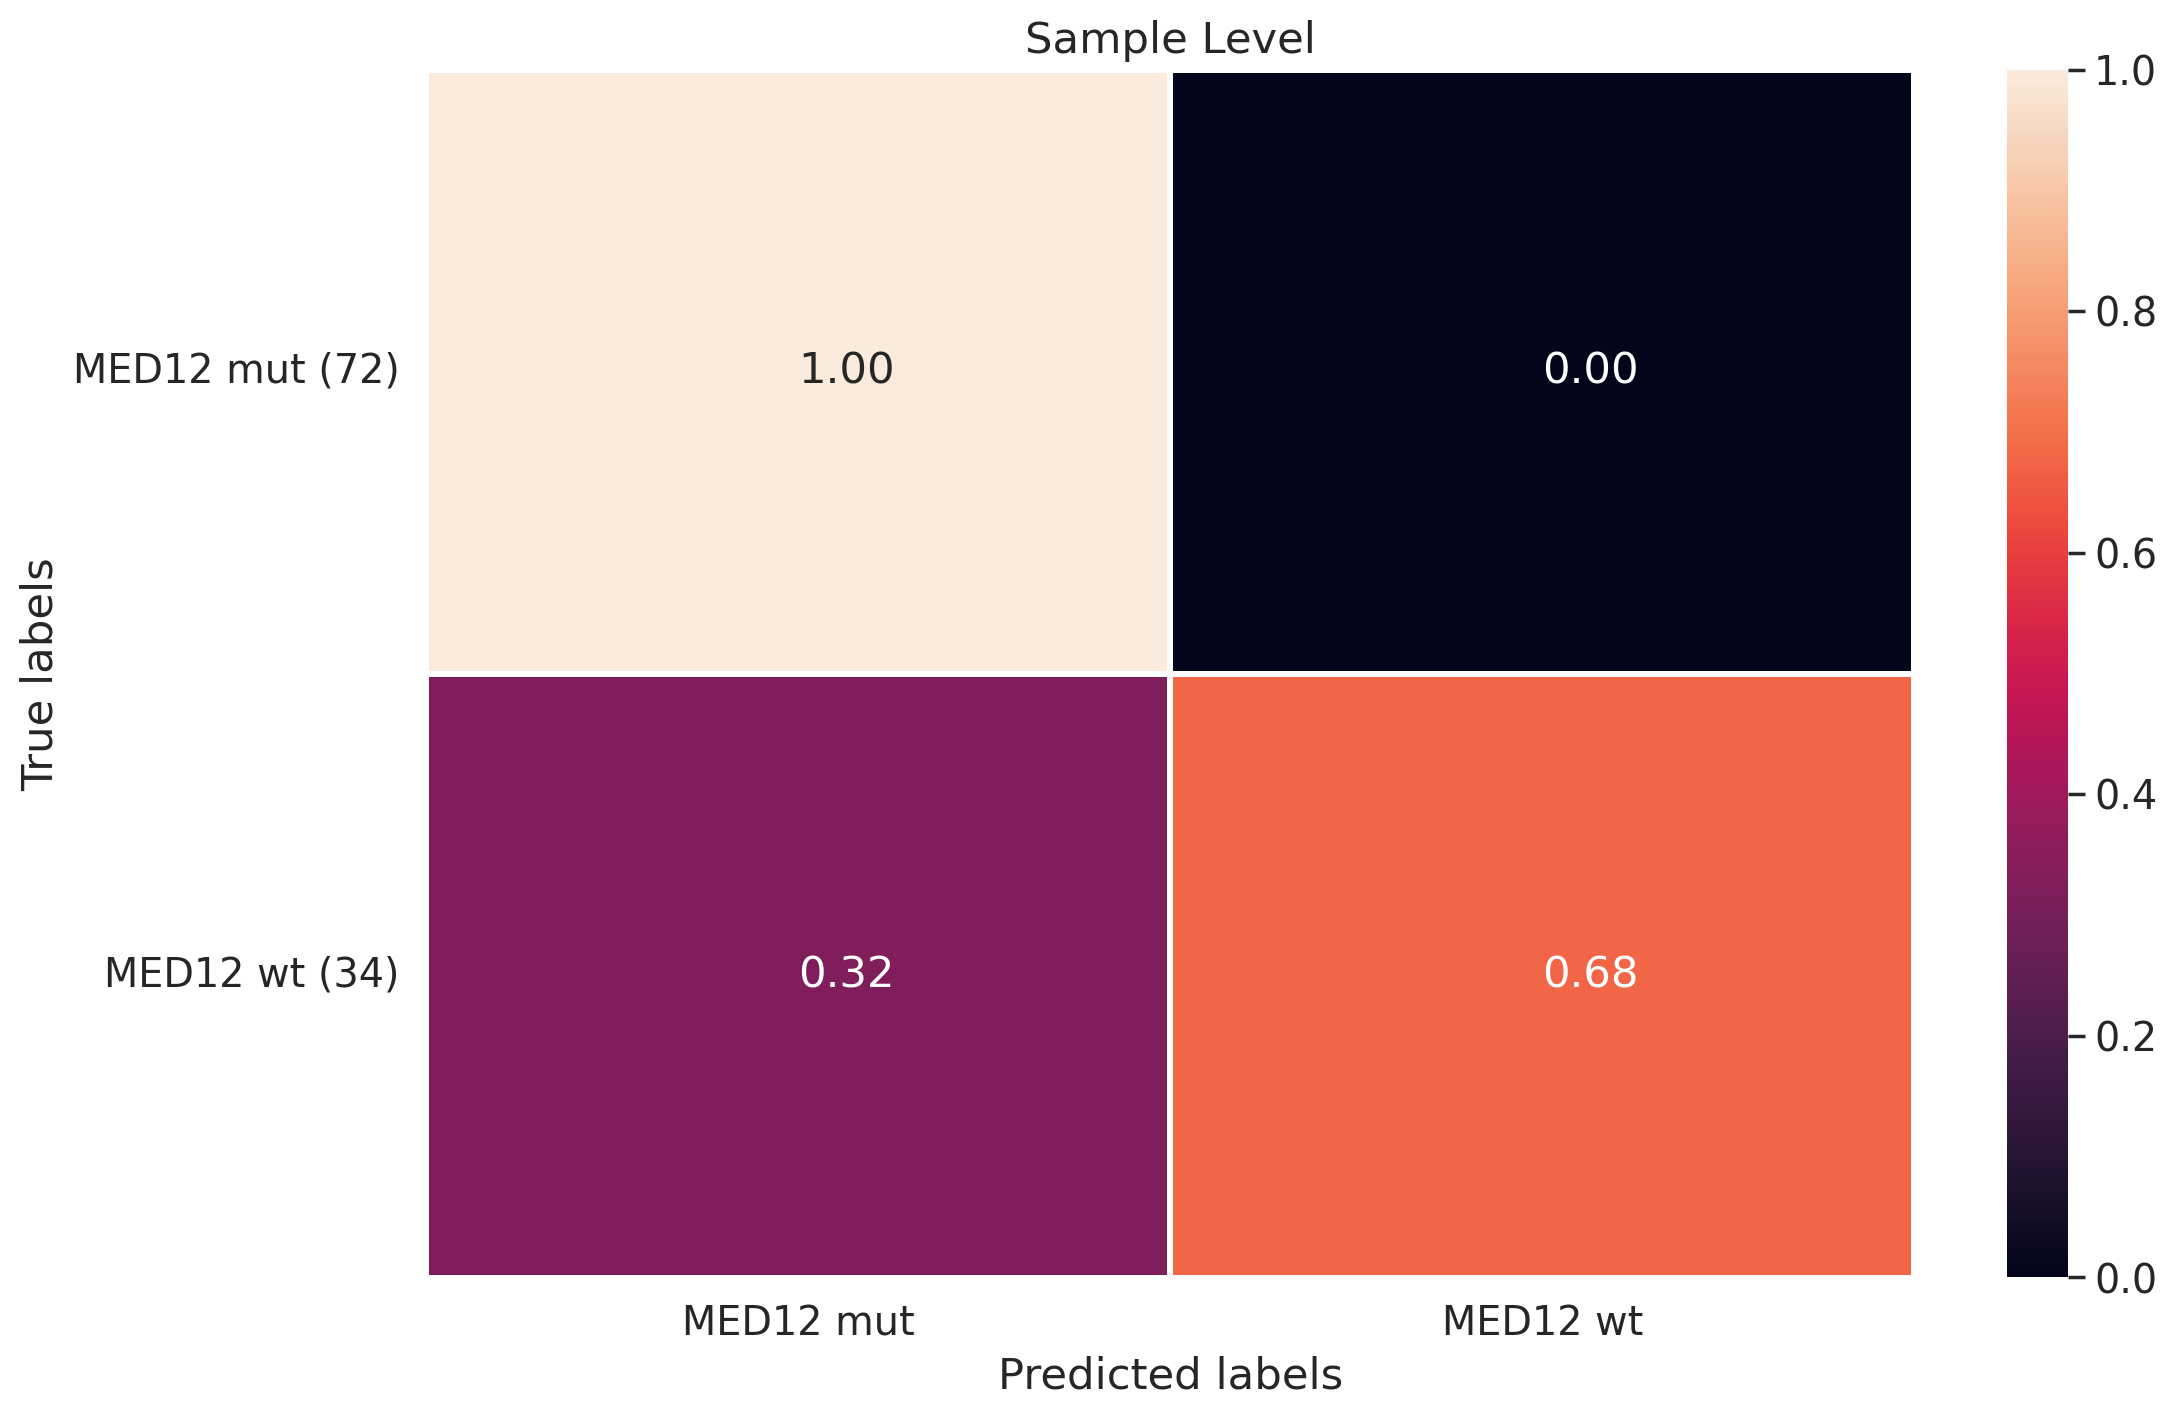

In [14]:
gt_sample = sample_level.loc[:,['Label']]

# get predictions into single column
# for confusion matrix
predictions = sample_level.loc[:,[0,1]].idxmax(axis= 1)

# probability for ROC
probs = sample_level.loc[:,[0,1]]

logger.debug("Confusion Matrix")
cm = confusion_matrix(gt_sample, predictions)
logger.info(cm)

target_names = ['MED12 mut ({:})'.format(np.sum(cm[0,:])),
                'MED12 wt ({:})'.format(np.sum(cm[1,:]))]
predict_names = ['MED12 mut', 'MED12 wt']

logger.debug("Classification Report")
cr = classification_report(gt_sample, predictions,
                            target_names=target_names,digits=3)
logger.info(cr)

## Add ROC and AUC
#auc = roc_auc_score(gt_tile, probs, multi_class='ovr')
#logger.info(auc_cm)
# Switch to percentage. Remember to switch sns.heatmap(fmt='.2e' to fmt='.2%')
cm = cm/cm.sum(axis=1, keepdims=True)


ax1 = plt.subplot(111)
akws = {"ha": 'left',"va": 'center'}

sns.set_theme(font_scale=1.3)
sns.heatmap(cm, annot=cm, ax = ax1, fmt='.2f', annot_kws=akws,linewidths=2,
            cbar =True, linecolor='white', vmin=0.,vmax=1.)

# labels, title and ticks
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.set_title("Sample Level")
ax1.xaxis.set_ticklabels(predict_names)
ax1.yaxis.set_ticklabels(target_names,rotation=0)
ax1.figure.set_size_inches((12,8))
ax1.figure.set_dpi(200)





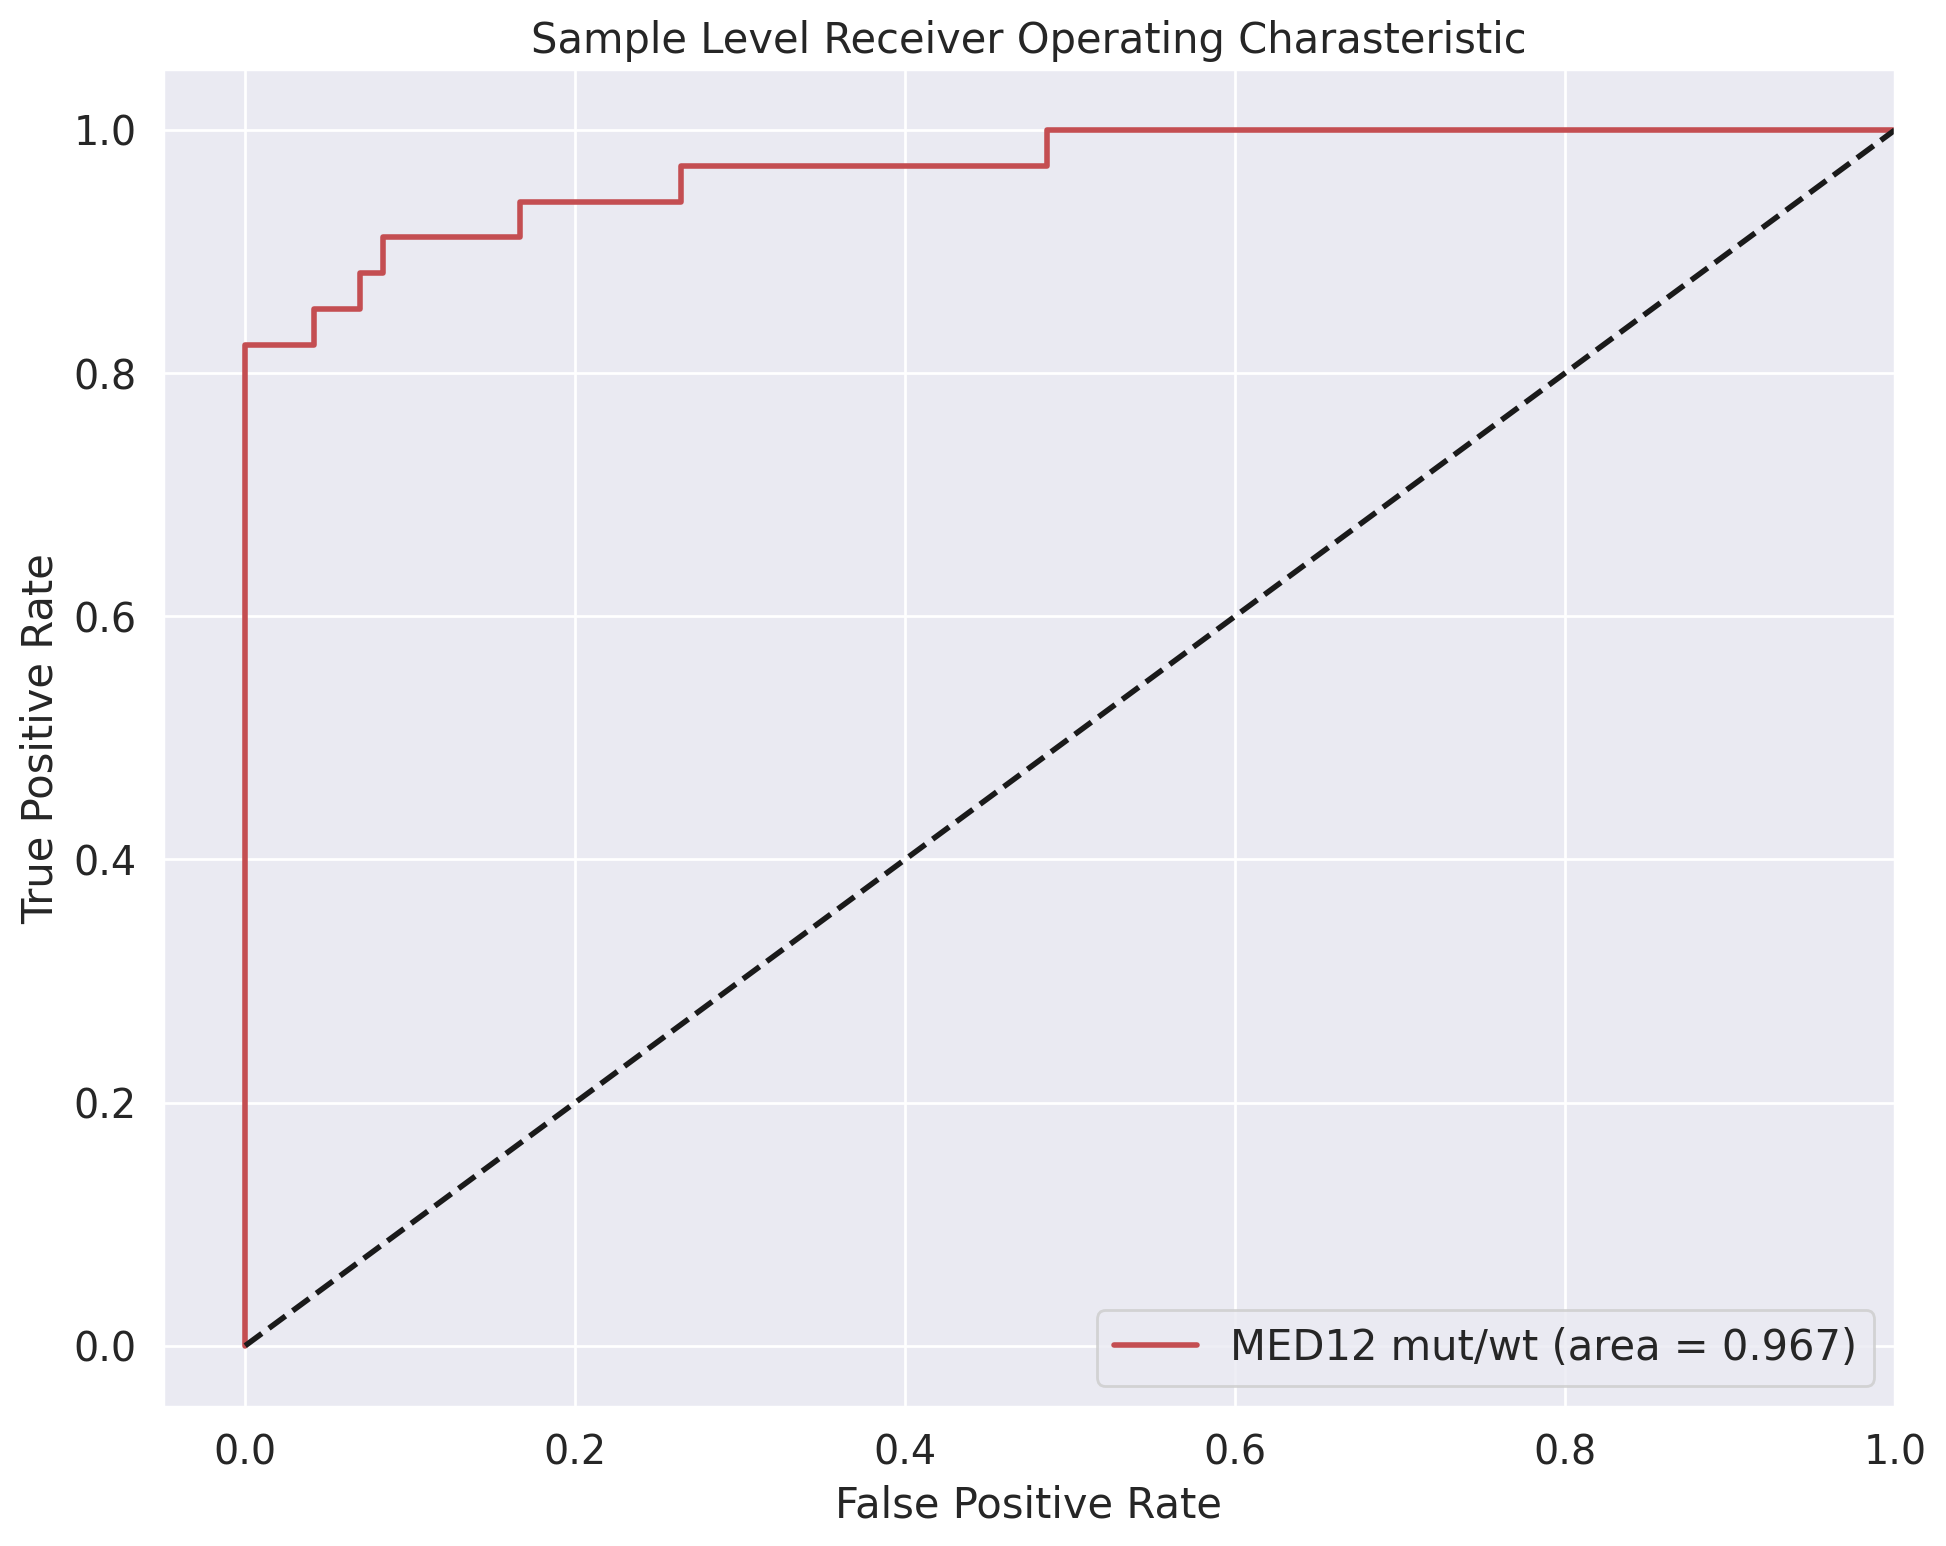

In [18]:
n_classes = 2
target_names = ['MED12 mut', 'MED12 wt']
lw = 2

results_mod = sample_level
gt_sample_mod = np.squeeze(np.array(gt_sample,dtype=np.int16))

gt_sample_mod = np.array(tf.one_hot(gt_sample_mod,n_classes),dtype=np.int16)
results_mod = np.array(results_mod.loc[:,[0,1]],dtype=np.float32)


fpr, tpr, _ = roc_curve(gt_sample_mod[:,1], results_mod[:,1])
roc_auc = auc(fpr, tpr)

# Then interpolate all ROC curves at this points
# Plot all ROC curves
plt.figure(figsize=(10, 8), dpi=200)

plt.plot(
    fpr,
    tpr,
    color='r',
    lw=lw,
    label= "MED12 mut/wt" + " (area = %0.3f)" % roc_auc,
)

plt.plot([0, 1], [0, 1], "k--", lw=lw,)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate",size=15)
plt.ylabel("True Positive Rate",size=15)
plt.title("Sample Level Receiver Operating Charasteristic",size=15)
plt.legend(loc="lower right",prop={'size': 15})
plt.tight_layout()
#plt.savefig(filename + '_ROC_tile_level.png', dpi=300)


In [25]:
sample_level[:20]

,Label,0,1,2,3
Sample,,,,,
My6098m1,2,0.000042,0.313590,0.423137,0.263230
My6098m2,1,0.000413,0.709702,0.167426,0.122455
My6141m1,1,0.003425,0.612344,0.114306,0.269921
My6141m10,1,0.027797,0.632449,0.207310,0.132442
My6141m2,1,0.007991,0.571155,0.234816,0.186035
My6141m3,1,0.014071,0.457387,0.509551,0.018988
My6141m4,1,0.005725,0.662428,0.202332,0.129512
My6141m5,1,0.011253,0.528102,0.320672,0.139974
My6141m6,1,0.036981,0.495710,0.376033,0.091273


In [21]:
sample_level_prediction_with_gt = pd.concat([gt_sample, pd.DataFrame(predictions,columns=['prediction'])], axis=1)

In [23]:

sample_level_prediction_with_gt[sample_level_prediction_with_gt['Label']!=sample_level_prediction_with_gt['prediction']]



,Label,prediction
Sample,,
My6141m3,1,2
My6141m8,1,2
My6152m2,1,2
My6152m3,1,2
My6152m4,1,2
My6152m5,1,2
My6189m1,2,3
My6209m1,2,0
My_6005_T2,1,0


In [57]:

# 85% overall accuracy
1-len(sample_level_prediction_with_gt[sample_level_prediction_with_gt['Label']!=sample_level_prediction_with_gt['prediction']])/len(sample_level_prediction_with_gt)



0.6301369863013699

In [58]:
p = df['Path'][0]

NameError: name 'df' is not defined

In [ ]:
df = results[results[1]>0.999].reset_index()

plt.figure(figsize=(30, 30))
for n in range(9):
    path = df['Path'][n]
    ax = plt.subplot(3,3,n+1)
    image = plt.imread(path)
    plt.imshow(image) 
    plt.title(path.split('/')[len(path.split('/'))-1],size=25)
    plt.axis("off")

In [ ]:
idx = 1
n_samples =10

In [ ]:
print("Segmenting and splitting slide {:n}/{:n}".format(idx,n_samples))